In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
import random
import pandas as pd

In [2]:
from sklearn.preprocessing import MinMaxScaler

# 数据预处理
path = r"../data/siping-4g-2.csv"


# 经纬度数据归一化处理
def preprocess(path):
    data = pd.read_csv(path)
    data = data.fillna(-1)  # 缺失值全部为-1
    yscaler = MinMaxScaler()
    yscaler.fit(data[['Longitude', 'Latitude']].values)

    return yscaler

yscaler = preprocess(path)
# print(yscaler)

In [5]:
# 构建时间序列

MRTime = [
1543994925358,
1543994928431,
1543994931521,
1543994934582,
1543994937645]

import datetime

# 计算时间差 以秒为单位
def compute_time_interval(timestamp1, timestamp2):
    dateArray1 = datetime.datetime.utcfromtimestamp(timestamp1 / 1000)
    dateArray2 = datetime.datetime.utcfromtimestamp(timestamp2 / 1000)
    # otherStyleTime = dateArray1.strftime("%Y-%m-%d %H:%M:%S")
    return float((dateArray2 - dateArray1).seconds)

ti = np.zeros((len(MRTime)))
for j in range(len(MRTime)):
    if j == 0:
        ti[j] = 0
    else:
        ti[j] = compute_time_interval(MRTime[j - 1], MRTime[j])
print(ti)

[0. 3. 3. 3. 3.]


In [3]:
import datetime

# 计算时间差 以秒为单位
def compute_time_interval(timestamp1, timestamp2):
    dateArray1 = datetime.datetime.utcfromtimestamp(timestamp1 / 1000)
    dateArray2 = datetime.datetime.utcfromtimestamp(timestamp2 / 1000)
    # otherStyleTime = dateArray1.strftime("%Y-%m-%d %H:%M:%S")
    return float((dateArray2 - dateArray1).seconds)


# 自变量字段信息
feature_col = ['RNCID_1', 'RNCID_2', 'RNCID_3', 'RNCID_4', 'RNCID_5', 'RNCID_6', 'RNCID_7',
               'CellID_1', 'CellID_2', 'CellID_3', 'CellID_4', 'CellID_5', 'CellID_6', 'CellID_7',
               'Dbm_1', 'Dbm_2', 'Dbm_3', 'Dbm_4', 'Dbm_5', 'Dbm_6', 'Dbm_7',
               'AsuLevel_1', 'AsuLevel_2', 'AsuLevel_3', 'AsuLevel_4', 'AsuLevel_5', 'AsuLevel_6', 'AsuLevel_7',
               'SignalLevel_1', 'SignalLevel_2', 'SignalLevel_3', 'SignalLevel_4', 'SignalLevel_5', 'SignalLevel_6', 'SignalLevel_7']


# 时间序列的最大长度
Max_S = 10

# 一个MR数据表征为一个7*5矩阵
bs_c = 7
col = 5


# 构造序列数据
def make_sequence1(data, yscaler, max_subs=Max_S):
    seq_list = []
    time_list = []
    loc_list = []
    mode_list = []
    # 根据Trajec ID 进行分组  --- 这是一段轨迹
    trajs = data.groupby(["TrajID"])
    max_seq = 0
    max_subseq = 0
    for trajid, traj in trajs:
        # 获取一段轨迹的信息
        dt = traj[feature_col].values
        # dt = xscaler.transform(traj[feature_col].values)

        # 将经纬度进行归一化
        lc = yscaler.transform(traj[['Longitude', 'Latitude']].values)
        tl = traj['MRTime'] # 记录MR的时间
        md = traj['mode']   # 数据的mode  run walk ...
        # traj = traj.sort_values(["MRTime"])
        _ = traj.shape[0] % max_subs
        c = int(traj.shape[0] / max_subs)

        if traj.shape[0] <= max_subs:
            seq = np.zeros((max_subs, bs_c * col))  # 序列数据结构： 10 * （7*5）
            loc = np.ones((max_subs, 2)) * (-1)     # 经纬度数据    10 * 2 
            # ti 时间戳
            t_tl, m_l, ti = np.zeros((max_subs)), np.zeros((max_subs)), np.zeros((max_subs))
            seq[0: traj.shape[0], :] = dt[0: traj.shape[0], :]      # 自变量序列
            loc[0: traj.shape[0], :] = lc[0: traj.shape[0], :]      # 经纬度
            t_tl[0: traj.shape[0]] = np.array(tl[0: traj.shape[0]]) # time序列
            m_l[0: traj.shape[0]] = md[0: traj.shape[0]]  # mode
            for j in range(traj.shape[0]):
                if j == 0:
                    ti[j] = 0
                else:
                    ti[j] = compute_time_interval(t_tl[j - 1], t_tl[j])
            seq_list.append(seq)   # 时间序列
            loc_list.append(loc)   # 
            time_list.append(ti)   # 时间戳序列
            mode_list.append(m_l)
        else:
            start = 0
            while start <= traj.shape[0] - max_subs - 1:
                seq = np.zeros((max_subs, bs_c * col))
                loc = np.ones((max_subs, 2)) * (-1)
                t_tl, m_l, ti = np.zeros((max_subs)), np.zeros((max_subs)), np.zeros((max_subs))
                #                 print (start, start+max_sub, seq[start: start + max_subs, :].shape, dt[start: start + max_subs, :].shape)
                seq = dt[start: start + max_subs, :]
                loc = lc[start: start + max_subs, :]
                t_tl = np.array(tl[start: start + max_subs])
                m_l = md[start: start + max_subs]
                #                 t_tl = np.array()
                for j in range(max_subs):
                    if j == 0:
                        ti[j] = 0
                    else:
                        ti[j] = compute_time_interval(t_tl[j - 1], t_tl[j])
                seq_list.append(seq)
                loc_list.append(loc)
                time_list.append(ti)
                mode_list.append(m_l)
                start += max_subs

            if start != traj.shape[0] - 1:
                seq = np.zeros((max_subs, bs_c * col))
                loc = np.ones((max_subs, 2)) * (-1)
                t_tl, m_l, ti = np.zeros((max_subs)), np.zeros((max_subs)), np.zeros((max_subs))
                seq[0: traj.shape[0] - start, :] = dt[start: traj.shape[0], :]
                loc[0: traj.shape[0] - start, :] = lc[start: traj.shape[0], :]
                t_tl[0: traj.shape[0] - start] = np.array(tl[start: traj.shape[0]])
                m_l[0: traj.shape[0] - start] = md[start: traj.shape[0]]
                for j in range(max_subs):
                    if j == 0:
                        ti[j] = 0
                    else:
                        ti[j] = compute_time_interval(t_tl[j - 1], t_tl[j])
                seq_list.append(seq)
                loc_list.append(loc)
                time_list.append(ti)
                mode_list.append(m_l)

    return seq_list, loc_list, time_list, mode_list


# 准备序列数据
def seq_sli(path):
    data = pd.read_csv(path)
    data = data.fillna(-1)  # -1填充
    a, b, c, d = [], [], [], []
    ea, eb, ec, ed = [], [], [], []
    te = pd.DataFrame()
    for i in range(5):
        tmp = data.loc[range(i, len(data), 5), :]
        if i < 4:
            ta, tb, tc, td = make_sequence1(tmp, yscaler)
        else:
            ta, tb, tc, td = make_sequence1(tmp, yscaler)
        if i == 0:
            a, b, c, d = ta, tb, tc, td
        elif i < 4:
            a.extend(ta)
            b.extend(tb)
            c.extend(tc)
            d.extend(td)
        else:
            ea, eb, ec, ed = ta, tb, tc, td

    train_dataset = np.array(a)
    train_label = np.array(b)
    train_time = np.array(c)
    train_mode = np.array(d)

    test_dataset = np.array(ea)
    test_label = np.array(eb)
    test_time = np.array(ec)
    test_mode = np.array(ed)

    return train_dataset, train_label, train_time, train_mode, test_dataset, test_label, test_time, test_mode

# 获取数据
tr_d, tr_l, tr_t, tr_m, te_d, te_l, te_t, te_m = seq_sli(path)

print(tr_d.shape)
print(tr_l.shape)
print(tr_t.shape)
print(tr_m.shape)

(705, 10, 35)
(705, 10, 2)
(705, 10)
(705, 10)


In [4]:
# 准备数据: 讲数据形状变为模型需要的形状
BATCH_S = 4   # batch_size
"""
fea: train_data （特征值）
lab: train_label（经纬度）
tl: time_list （时间序列）
md: mode list
"""

def data_prepare(fea, lab, tl, md):
    batch_size = BATCH_S
    f, l, t, d = [], [], [], []
    _ = fea.shape[0] % batch_size
    batch_cnt = int(fea.shape[0] / batch_size)
    if _ != 0:
        batch_cnt += 1
    for i in range(0, batch_cnt):
        tmp_f = np.zeros((batch_size * Max_S, bs_c, col, 1))
        tmp_l = np.ones((batch_size * Max_S, 2)) * (-1)
        tmp_t = np.ones((batch_size * Max_S)) * (-1)
        tmp_m = np.ones((batch_size * Max_S)) * (-1)
        if i < batch_cnt - 1:
            for j in range(0, batch_size):
                f_t = fea[i * batch_size + j, :, :].reshape([Max_S, bs_c, col, 1])
                l_t = lab[i * batch_size + j, :]
                t_t = tl[i * batch_size + j]
                m_t = md[i * batch_size + j]
                for m in range(0, Max_S):
                    #                     print (j, m, j*Max_S+m)
                    tmp_f[j * Max_S + m, :, :, :] = f_t[m, :, :, :]
                    tmp_l[j * Max_S + m, :] = l_t[m, :]
                    tmp_t[j * Max_S + m] = t_t[m]
                    tmp_m[j * Max_S + m] = m_t[m]
        else:
            if _ == 0:
                for j in range(0, batch_size):
                    f_t = fea[i * batch_size + j, :, :].reshape([Max_S, bs_c, col, 1])
                    l_t = lab[i * batch_size + j, :]
                    t_t = tl[i * batch_size + j]
                    m_t = md[i * batch_size + j]
                    for m in range(0, Max_S):
                        tmp_f[j * Max_S + m, :, :, :] = f_t[m, :, :, :]
                        tmp_l[j * Max_S + m, :] = l_t[m, :]
                        tmp_t[j * Max_S + m] = t_t[m]
                        tmp_m[j * Max_S + m] = m_t[m]
            else:
                for j in range(0, _):
                    f_t = fea[i * batch_size + j, :, :].reshape([Max_S, bs_c, col, 1])
                    l_t = lab[i * batch_size + j, :]
                    t_t = tl[i * batch_size + j]
                    m_t = md[i * batch_size + j]
                    for m in range(0, Max_S):
                        tmp_f[j * Max_S + m, :, :, :] = f_t[m, :, :, :]
                        tmp_l[j * Max_S + m, :] = l_t[m, :]
                        tmp_t[j * Max_S + m] = t_t[m]
                        tmp_m[j * Max_S + m] = m_t[m]

                for j in range(_, batch_size):
                    f_t = fea[(i - 1) * batch_size + (_ - 1), :, :].reshape([Max_S, bs_c, col, 1])
                    l_t = lab[(i - 1) * batch_size + (_ - 1), :]
                    t_t = tl[(i - 1) * batch_size + (_ - 1)]
                    m_t = md[(i - 1) * batch_size + (_ - 1)]
                    for m in range(0, Max_S):
                        tmp_f[j * Max_S + m, :, :, :] = f_t[m, :, :, :]
                        tmp_l[j * Max_S + m, :] = l_t[m, :]
                        tmp_t[j * Max_S + m] = t_t[m]
                        tmp_m[j * Max_S + m] = m_t[m]

        f.append(tmp_f)
        l.append(tmp_l)
        t.append(tmp_t)
        d.append(tmp_m)

    return f, l, t, d


def re_npy(path):
    tr_d, tr_l, tr_t, tr_m, te_d, te_l, te_t, te_m = seq_sli(path)
    # 构建训练数据集  形状
    f, l, t, m = data_prepare(tr_d, tr_l, tr_t, tr_m)
    f = np.array(f)
    l = np.array(l)
    t = np.array(t)
    m = np.array(m)
    # 构建测试数据集 形状
    ef, el, et, em = data_prepare(te_d, te_l, te_t, te_m)
    ef = np.array(ef)
    el = np.array(el)
    et = np.array(et)
    em = np.array(em)

    return f, l, m, t, ef, el, em, et

f, l, m, t, ef, el, em, et = re_npy(path)

print(f.shape)
print(l.shape)
print(m.shape)
print(t.shape)
print(ef.shape)
print(el.shape)
print(em.shape)
print(et.shape)

(177, 40, 7, 5, 1)
(177, 40, 2)
(177, 40)
(177, 40)
(45, 40, 7, 5, 1)
(45, 40, 2)
(45, 40)
(45, 40)


In [5]:
# 计算 m_hist
import math

def rad(d):
    return d * math.pi / 180.0

# 计算真假误差
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a / 2), 2) +
                                math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b / 2), 2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

def mode_dict(path):
    data = pd.read_csv(path)
    data = data.fillna(-1)
    trajs = data.groupby(["TrajID"])
    m_d = {}
    m_d[0] = []
    m_d[1] = []
    m_d[2] = []
    for trajid, traj in trajs:
        md = list(traj['mode'])
        loc = traj[['Longitude', 'Latitude']].values
        tl = list(traj['MRTime'])
        for j in range(1, traj.shape[0]):
            if j > 0:
                delta_t = compute_time_interval(tl[j - 1], tl[j])
                delta_s = distance(loc[j - 1, :], loc[j, :])
                m = int(md[j])
                if delta_t > 0:
                    m_d[m].append(delta_s / delta_t)
    return m_d

def speed_hist(mode_dict):
    mode_hist_dict = {}
    for key, value in mode_dict.items():
        tmp = np.zeros((7))
        for t in value:
            if t <= 2:
                tmp[0] += 1
            elif t <= 6:
                tmp[1] += 1
            elif t <= 12:
                tmp[2] += 1
            elif t <= 18:
                tmp[3] += 1
            elif t <= 24:
                tmp[4] += 1
            elif t <= 30:
                tmp[5] += 1
            else:
                tmp[6] += 1
        prob = []
        if len(value) > 0:
            for t in tmp:
                prob.append(float(t) / float(len(value)))
        mode_hist_dict[key] = prob

    return mode_hist_dict

_ = mode_dict(path)
# print(_)
m_hist = speed_hist(_)
print(m_hist)

{0: [0.6874024526198439, 0.26666666666666666, 0.037235228539576365, 0.004905239687848384, 0.0017837235228539577, 0.0006688963210702341, 0.0013377926421404682], 1: [0.2745176848874598, 0.510048231511254, 0.20016077170418006, 0.013665594855305467, 0.0008038585209003215, 0.00040192926045016077, 0.00040192926045016077], 2: [0.08018867924528301, 0.23702830188679244, 0.49174528301886794, 0.15566037735849056, 0.02358490566037736, 0.0047169811320754715, 0.007075471698113208]}


In [9]:
# 输入层
tf.keras.layers.Conv2D(filters=64,        # 卷积中滤波器的输出数量
                       kernel_size=(1, 5),# 卷积核
                       padding='valid',   # 多余的列舍弃
                       strides=(1, 1),    # 步长
                       input_shape=(7, 5, 1),# 输入形状 
                       activation='relu')    # 激活函数
# 输出层
tf.keras.layers.Dense(2, activation='sigmoid')

In [25]:
# 训练模型

mode_class_num = 3


class Local(tf.keras.layers.Layer):
    def __init__(self, latent_dim=64, intermediate_dim=128, name='Local', **kwargs):
        super(Local, self).__init__(name=name, **kwargs)
        self.cnn = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, col), padding='valid',
                                          input_shape=(7, col, 1), activation='relu', name='localcnn')
        self.bn = tf.keras.layers.BatchNormalization(name='localbn')  # 把一个batch内的所有数据，从不规范的分布拉到正态分布
        self.dropout = tf.keras.layers.Dropout(0.2, name='localdrop') # 防止过拟合，随机0.2的不进行工作
        # self.reshape = tf.keras.layers.Reshape((7, 64), name='localreshape')  # 任意层之间连接 LSTM
        self.reshape = tf.keras.layers.Reshape((1, -1), name='localreshape')  # 任意层之间连接 CNN
        self.lstm  = tf.keras.layers.Dense(128, activation='relu', name='localdense1') # 输出维度128  # 不适用LSTM 纯CNN
#         self.lstm = tf.keras.layers.LSTM(128, return_sequences=False, stateful=False, name='locallstm') # 使用LSTM
        self.dense_1 = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='localdense1') # 输出维度128
        self.dense_2 = tf.keras.layers.Dense(latent_dim, activation='relu', name='localdense2')       # 输出维度 64

    def call(self, inputs):
        cnn_bn = self.bn(self.cnn(inputs))
        cnn_drop = self.dropout(cnn_bn)
        lstm_inp = self.reshape(cnn_drop)
        # print (lstm_inp.shape)
        lstm_out = self.lstm(lstm_inp)
        lstm_drop = self.dropout(lstm_out)
        dense_1 = self.dropout(self.dense_1(lstm_drop))
        local_out = self.dense_2(dense_1)   # 64维度的数据
        return local_out

    def get_config(self):
        config = super(Local, self).get_config()
        return config


class Attention(tf.keras.layers.Layer):
    def __init__(self, attention_size=32, name='Attention', **kwargs):
        super().__init__(name=name, **kwargs)
        self.attention_size = attention_size    # 输入32维
        self.dense_1 = tf.keras.layers.Dense(attention_size, activation='tanh', name='attndnese1')  # 全连接 32
        self.dense_2 = tf.keras.layers.Dense(1, use_bias=False, name='attndense2')   # 全连接 1维

    def call(self, inputs):
        v = self.dense_1(inputs)
        vu = self.dense_2(v)
        alphas = tf.nn.softmax(vu)   # 一维数据经过 softmax  映射到0和1之间
        output = alphas
        return output

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"attention_size": self.attention_size})
        return config


import AttentionCell
from imp import reload

reload(AttentionCell)

class Global(tf.keras.layers.Layer):
    def __init__(self, max_subs=Max_S, latent_dim=64, name='Global', **kwargs):
        super(Global, self).__init__(name=name, **kwargs)
        self.max_subs = max_subs

        self.cell = AttentionCell.ALSTM_Cell(64, name='attncell')  # 注意力机制：输入64维度
        self.rnn = tf.keras.layers.RNN(self.cell, return_sequences=True, name='attnRNN')  # RNN中使用Attention Cell
        self.dense_1 = tf.keras.layers.Dense(64, activation='relu', 
                                             name='globaldense1')  # tf.keras.layers.BatchNormalization(), 全连接 64层
        self.dense_2 = tf.keras.layers.Dense(32, activation='relu', name='globaldense2')   # 全连接 32 层
        self.out = tf.keras.layers.Dense(2, activation='sigmoid', name='globalout')        # 全连接 2 层
        self.attn = Attention(name='globalattn')

    def call(self, inputs):
        x = inputs
        # mask = self.mask(x)
        h = self.rnn(x)   # 接受64维度数据
        h_d_1 = self.dense_1(h)      # 64
        h_d_2 = self.dense_2(h_d_1)  # 32
        h_a = self.attn(h_d_2)       # 使用Attention  返回结果为一维数据，映射在0-1之间
        y = self.out(h_d_2 * h_a)    # 输出2维数据     32维数据与0-1之间一个数据相乘，然后映射为2维数据
        return y

    def get_config(self):
        config = super(Global, self).get_config()
        config.update({"max_subs": self.max_subs})
        return config

class Seq(tf.keras.Model):
    def __init__(self, latent_dim=64, intermediate_dim=128, name='Seq', **kwargs):
        super().__init__(name=name, **kwargs)
        self.local_out_dim = latent_dim
        self.local = Local(latent_dim=latent_dim, intermediate_dim=intermediate_dim, name='seqlocal')   # 输出64 维度的数据
        self.pred = Global(name='seqglobal')

    def call(self, inputs):
        batch_inputs = inputs[0]
        batch_time = inputs[1]

        x = self.local(batch_inputs)
        x = tf.reshape(x, [BATCH_S, Max_S, self.local_out_dim])
        batch_time = tf.reshape(batch_time, [BATCH_S, Max_S, 1])
        x = tf.keras.layers.concatenate([x, batch_time], axis=-1)
        x = self.pred(x)

        return x

    def get_config(self):
        config = super(Seq, self).get_config()
        config.update({"local_out_dim": self.local_out_dim})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [26]:
raw_model = Seq()

# print(raw_model)

In [8]:
# 自定义评判指标
def proba(v, mode, m_hist):
    prob = 0
    if mode >= 0:
        ref = m_hist[mode]
        if v <= 2:
            prob = ref[0]
        elif v <= 6:
            prob = ref[1]
        elif v <= 12:
            prob = ref[2]
        elif v <= 18:
            prob = ref[3]
        elif v <= 24:
            prob = ref[4]
        elif v <= 30:
            prob = ref[5]
        else:
            prob = ref[6]
    return prob

def mode_const(y_pred, time_list, mode_list, yscaler, m_hist):
    sum_p = 0
    c = 0
    for i in range(1, y_pred.shape[0]):
        mode = int(mode_list[i].numpy())
        if mode >= 0:
            loc_former = yscaler.inverse_transform(y_pred[i - 1, :].reshape(1, 2))
            loc_later = yscaler.inverse_transform(y_pred[i, :].reshape(1, 2))
            dis = distance(loc_former[0], loc_later[0])
            v = dis / time_list[i]
            p = - math.log(1 + proba(v, mode, m_hist))
            sum_p += p
            c += 1
    if c > 0:
        return sum_p / c
    else:
        return 0


def loss_function_const(y_true, y_pred, time_list, mode_list, yscaler, m_hist):
    judge = tf.math.equal(y_true, -1.0)  # 经纬度不能等于 -1 [True, False]
    mask = tf.math.logical_not(tf.math.logical_and(judge[:, 0], judge[:, 1]))

    loss_ = tf.keras.losses.MSE(y_true, y_pred)
    loss_ = tf.cast(loss_, dtype='float32')
    count = tf.math.count_nonzero(mask)
    count = tf.cast(count, dtype='float32')
    mask = tf.cast(mask, dtype='float32')
    loss_ *= mask

    constraint = mode_const(y_pred.numpy(), time_list, mode_list, yscaler, m_hist)
    thres_alpha = 0.05

    return tf.reduce_sum(loss_) / (count + 1) + thres_alpha * constraint


def predict_t(model, fea, lab, time, lox_sel, batch_size=BATCH_S):
    pred = []
    true = []
    for i in range(0, fea.shape[0]):
        x_batch = fea[i, :, :, :, :]
        y_batch = lab[i, :, :].reshape((batch_size * Max_S, 2))
        t_batch = time[i, :]
        x_batch = tf.cast(x_batch, tf.float32)
        t_batch = tf.cast(t_batch, tf.float32)
        batch_input = []
        batch_input.append(x_batch)
        batch_input.append(t_batch)

        #         pred_batch = model(x_batch, t_batch)
        if lox_sel == 0:
            pred_batch = model(batch_input)
        else:
            pred_batch, _ = model(batch_input)
        pred_batch = tf.reshape(pred_batch, [batch_size * Max_S, 2]).numpy()
        if i == 0:
            pred = pred_batch
            true = y_batch
        else:
            pred = np.concatenate((pred, pred_batch), axis=0) # 拼接
            true = np.concatenate((true, y_batch), axis=0)
    return pred, true

def f_error(tr_loc, Y, yscaler):
    err = []
    m = 0

    while m < tr_loc.shape[0]:
        if Y[m, 0] != -1.0 and Y[m, 1] != -1.0:
            tr_loc_real = yscaler.inverse_transform(tr_loc[m, :].reshape(1, 2))
            y_true_real = yscaler.inverse_transform(Y[m, :].reshape(1, 2))
            err.append(distance(tr_loc_real.reshape(2), y_true_real.reshape(2)))
        m += 1

    # print(m)
    return err

In [9]:
x_batch_train = f[0, :, :, :, :]
y_batch_train = l[0, :, :]
t_batch_time = t[0, :]
m_batch_time = m[0, :]

print(type(x_batch_train))
print(x_batch_train.shape)  # samples
print(y_batch_train.shape)  # labels
print(t_batch_time.shape)
print(m_batch_time.shape)

<class 'numpy.ndarray'>
(40, 7, 5, 1)
(40, 2)
(40,)
(40,)


In [27]:
Max_S = 10
lox_sel = 0
# 优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
# 损失函数
loss_metric = tf.keras.metrics.Mean()

m_med_err = 999
m_mea_err = 999
m_nin_err = 999
max_acc = 0

shuffle_list = random.sample(range(f.shape[0]), f.shape[0])

yscaler = preprocess(path)
# print("yscaler: ", yscaler.feature_range)

# 训练轮数
epoches = 100

median_loss = []
mean_loss = []
nine_loss = []
all_loss = []

for epoch in range(0, epoches):
    print("=====>第{}轮训练开始：".format(epoch))
    los = []
    for j in shuffle_list:
        x_batch_train = f[j, :, :, :, :]
        y_batch_train = l[j, :, :]
        t_batch_time = t[j, :]
        m_batch_time = m[j, :]
        x_batch_train = tf.cast(x_batch_train, tf.float32)
        y_batch_train = tf.cast(y_batch_train, tf.float32)
        t_batch_time = tf.cast(t_batch_time, tf.float32)
        m_batch_time = tf.cast(m_batch_time, tf.float32)
        batch_input = []
        #         print (x_batch_train.shape, t_batch_time.shape)
        batch_input.append(x_batch_train)
        batch_input.append(t_batch_time)

        with tf.GradientTape() as tape:
            tape.watch(raw_model.trainable_variables)
            pred = raw_model(batch_input)
            pred = tf.reshape(pred, [BATCH_S * Max_S, 2])

            loss = loss_function_const(y_batch_train, pred, t_batch_time, m_batch_time, yscaler, m_hist)

        grads = tape.gradient(loss, raw_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, raw_model.trainable_variables))
        loss_metric(loss)
        los.append(loss)
        if j % 50 == 0:
            print('step %s: loss = %s' % (j, loss))

    all_loss.append(los)
    # if epoch % 10 == 0 and epoch <= 400:
    pred, true = predict_t(raw_model, ef, el, et, lox_sel)
    te_err = sorted(f_error(pred, true, yscaler))
    median_loss.append(np.median(te_err))
    mean_loss.append(np.mean(te_err))
    nine_loss.append(te_err[int(len(te_err) * 0.9)])
    print("轮数：{}, 中位数误差:{}, 平均误差：{}, 90%误差：{}".format(epoch, np.median(te_err), np.mean(te_err), te_err[int(len(te_err) * 0.9)]))

=====>第0轮训练开始：
step 150: loss = tf.Tensor(0.021363527, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.062812, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.045315634, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.016253151, shape=(), dtype=float32)
轮数：0, 中位数误差:292.55, 平均误差：301.1144953051643, 90%误差：515.1
=====>第1轮训练开始：
step 150: loss = tf.Tensor(0.00952547, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.070595495, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.049058277, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.016975518, shape=(), dtype=float32)
轮数：1, 中位数误差:288.7, 平均误差：300.12593896713616, 90%误差：509.5
=====>第2轮训练开始：
step 150: loss = tf.Tensor(0.0129216015, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.069361925, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.049810514, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.016810458, shape=(), dtype=float32)
轮数：2, 中位数误差:289.9, 平均误差：302.22411971830985, 90%误差：513.7
=====>第3轮训练开始：
step

step 150: loss = tf.Tensor(0.008920591, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.07096613, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.055027813, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018703341, shape=(), dtype=float32)
轮数：25, 中位数误差:276.85, 平均误差：298.74237089201876, 90%误差：490.8
=====>第26轮训练开始：
step 150: loss = tf.Tensor(0.008903025, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.071041726, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.054896824, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.01861709, shape=(), dtype=float32)
轮数：26, 中位数误差:276.25, 平均误差：298.62799295774647, 90%误差：491.3
=====>第27轮训练开始：
step 150: loss = tf.Tensor(0.008906957, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.07111851, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.05475717, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018561639, shape=(), dtype=float32)
轮数：27, 中位数误差:275.85, 平均误差：298.5644366197183, 90%误差：490.9
=====>第28轮训练开始：
step 150: lo

step 150: loss = tf.Tensor(0.00881182, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.0713393, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.055039123, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018395834, shape=(), dtype=float32)
轮数：50, 中位数误差:275.2, 平均误差：298.19548122065726, 90%误差：490.8
=====>第51轮训练开始：
step 150: loss = tf.Tensor(0.008828267, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.07123697, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.05533489, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018369548, shape=(), dtype=float32)
轮数：51, 中位数误差:275.05, 平均误差：298.1647300469483, 90%误差：491.4
=====>第52轮训练开始：
step 150: loss = tf.Tensor(0.008814603, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.0712387, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.0553265, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.01837691, shape=(), dtype=float32)
轮数：52, 中位数误差:275.05, 平均误差：298.1595070422535, 90%误差：491.4
=====>第53轮训练开始：
step 150: loss = tf.

step 150: loss = tf.Tensor(0.00880317, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.07140068, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.055777125, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018367823, shape=(), dtype=float32)
轮数：75, 中位数误差:275.5, 平均误差：297.9847417840375, 90%误差：491.5
=====>第76轮训练开始：
step 150: loss = tf.Tensor(0.008800216, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.071333684, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.055637248, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018562004, shape=(), dtype=float32)
轮数：76, 中位数误差:272.35, 平均误差：299.06203051643195, 90%误差：500.3
=====>第77轮训练开始：
step 150: loss = tf.Tensor(0.008783603, shape=(), dtype=float32)
step 100: loss = tf.Tensor(0.071472645, shape=(), dtype=float32)
step 0: loss = tf.Tensor(0.05590658, shape=(), dtype=float32)
step 50: loss = tf.Tensor(0.018358972, shape=(), dtype=float32)
轮数：77, 中位数误差:275.5, 平均误差：297.962441314554, 90%误差：491.3
=====>第78轮训练开始：
step 150: loss 

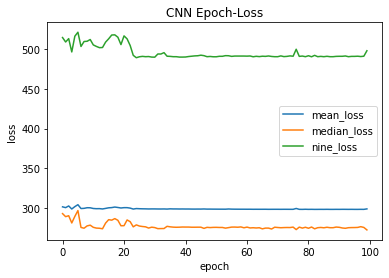

In [33]:
# 画图
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN Epoch-Loss")

plt.plot(x, mean_loss, label='mean_loss')
plt.plot(x, median_loss, label='median_loss')
plt.plot(x, nine_loss, label='nine_loss')

plt.legend()
plt.show()

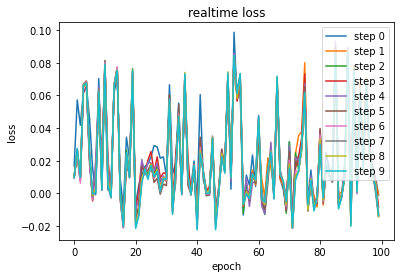

In [34]:
new_loss = []
for row in all_loss:
    r = []
    for d in row:
        r.append(d.numpy())
    new_loss.append(r)

x = [i for i in range(100)]

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("realtime loss")
for i in range(10):
    aloss = all_loss[i]
    plt.plot(x, aloss[:100], label='step '+ str(i))
plt.legend()
plt.show()

In [36]:
raw_model.save("./model/model") 

INFO:tensorflow:Assets written to: ./model/model.pb\assets


INFO:tensorflow:Assets written to: ./model/model.pb\assets


In [ ]:
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import os  # 系统环境变量失效
os.environ["PATH"] += os.pathsep + r'D:/AppData/graphviz/bin'  # 解决问题


# 绘制模型
plot_model(raw_model,to_file='cnn_model.png', show_shapes=True, show_layer_names='True', rankdir='TB') # LR

plt.figure(figsize=(80,80))
img = plt.imread('cnn_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [17]:
print(median_loss)
print(mean_loss)
print(nine_loss)
print(all_loss)

In [141]:
new_loss = []
for row in all_loss:
    r = []
    for d in row:
        r.append(d.numpy())
    new_loss.append(r)

In [137]:
import csv
filePath = './loss/all.csv'
rows = zip(median_loss,mean_loss,nine_loss)
with open(filePath, "w", newline='') as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [142]:
def save_as_csv(array,path):
    """将数组保存在.csv文件中"""
    data = pd.DataFrame(array)
    data.to_csv(path)

save_as_csv(mean_loss, './loss/mean_loss.csv')
save_as_csv(median_loss, './loss/median_loss.csv')
save_as_csv(nine_loss, './loss/nine_loss.csv')
save_as_csv(new_loss, './loss/all_loss.csv')

In [ ]:
# 读取loss数据进行可视化
import pandas as pd

mean_loss = pd.read_csv("./loss/mean_loss.csv")
mean_loss = list(mean_loss['0'])
median_loss = pd.read_csv("./loss/median_loss.csv")
median_loss = list(median_loss['0'])
nine_loss = pd.read_csv("./loss/nine_loss.csv")
nine_loss = list(nine_loss['0'])

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Attention LSTM Epoch-Loss")

plt.plot(x, mean_loss, label='mean_loss')
plt.plot(x, median_loss, label='median_loss')
plt.plot(x, nine_loss, label='nine_loss')

plt.legend()
plt.show()

In [ ]:
all_loss = pd.read_csv("./loss/all_loss.csv")
print(all_loss.head())

In [ ]:
x = [i for i in range(100)]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("realtime loss")
for i in range(10):
    aloss = list(all_loss[str(i)])
    plt.plot(x, aloss, label='step '+str(i))
plt.legend()
plt.show()

In [15]:
# 读取loss数据进行可视化
import pandas as pd

mean_loss = pd.read_csv("./loss/mean_loss.csv")
mean_loss = list(mean_loss['0'])
median_loss = pd.read_csv("./loss/median_loss.csv")
median_loss = list(median_loss['0'])
nine_loss = pd.read_csv("./loss/nine_loss.csv")
nine_loss = list(nine_loss['0'])

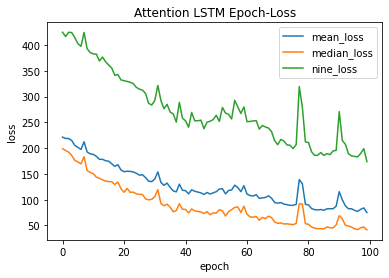

In [20]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Attention LSTM Epoch-Loss")

plt.plot(x, mean_loss, label='mean_loss')
plt.plot(x, median_loss, label='median_loss')
plt.plot(x, nine_loss, label='nine_loss')

plt.legend()
plt.show()

In [22]:
all_loss = pd.read_csv("./loss/all_loss.csv")
print(all_loss.head())

   Unnamed: 0         0         1         2         3         4         5  \
0           0 -0.003473  0.044923  0.023767  0.033398  0.018113  0.009119   
1           1 -0.003835  0.042122  0.021455  0.034114  0.019799  0.006299   
2           2 -0.003455  0.040949  0.021230  0.034173  0.024009  0.007586   
3           3 -0.003213  0.039993  0.023174  0.031574  0.021564  0.008117   
4           4 -0.003315  0.036031  0.020619  0.035509  0.021319  0.006258   

          6         7         8  ...       167       168       169       170  \
0  0.004431  0.019725 -0.005226  ... -0.004461  0.023196  0.030197  0.012459   
1  0.009809  0.025336 -0.000860  ... -0.006340  0.019789  0.025499  0.014253   
2  0.009428  0.026535 -0.000758  ... -0.005808  0.018700  0.023857  0.013688   
3  0.009262  0.025200 -0.000984  ... -0.003304  0.018143  0.021187  0.012747   
4  0.008643  0.023400  0.000029  ... -0.005691  0.017865  0.021469  0.010979   

        171       172       173       174       175     

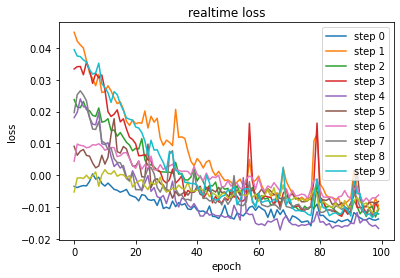

In [30]:
x = [i for i in range(100)]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("realtime loss")
for i in range(10):
    aloss = list(all_loss[str(i)])
    plt.plot(x, aloss, label='step '+str(i))
plt.legend()
plt.show()

In [ ]:
# 训练模型

mode_class_num = 3


class Local(tf.keras.layers.Layer):
    def __init__(self, latent_dim=64, intermediate_dim=128, name='Local', **kwargs):
        super(Local, self).__init__(name=name, **kwargs)
        self.cnn = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, col), padding='valid',
                                          input_shape=(7, col, 1), activation='relu', name='localcnn')
        self.bn = tf.keras.layers.BatchNormalization(name='localbn')  # 把一个batch内的所有数据，从不规范的分布拉到正态分布
        self.dropout = tf.keras.layers.Dropout(0.2, name='localdrop') # 防止过拟合，随机0.2的不进行工作
        self.reshape = tf.keras.layers.Reshape((7, 64), name='localreshape')  # 任意层之间连接
        self.lstm = tf.keras.layers.LSTM(128, return_sequences=False, stateful=False, name='locallstm') # 输出维度？
        self.dense_1 = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='localdense1') # 输出维度128
        self.dense_2 = tf.keras.layers.Dense(latent_dim, activation='relu', name='localdense2')       # 输出维度 64

    def call(self, inputs):
        cnn_bn = self.bn(self.cnn(inputs))
        cnn_drop = self.dropout(cnn_bn)
        lstm_inp = self.reshape(cnn_drop)
        # print (lstm_inp.shape)
        lstm_out = self.lstm(lstm_inp)
        lstm_drop = self.dropout(lstm_out)
        dense_1 = self.dropout(self.dense_1(lstm_drop))
        local_out = self.dense_2(dense_1)   # 64维度的数据
        return local_out

    def get_config(self):
        config = super(Local, self).get_config()
        return config


class Attention(tf.keras.layers.Layer):
    def __init__(self, attention_size=32, name='Attention', **kwargs):
        super().__init__(name=name, **kwargs)
        self.attention_size = attention_size    # 输入32维
        self.dense_1 = tf.keras.layers.Dense(attention_size, activation='tanh', name='attndnese1')  # 全连接 32
        self.dense_2 = tf.keras.layers.Dense(1, use_bias=False, name='attndense2')   # 全连接 1维

    def call(self, inputs):
        v = self.dense_1(inputs)
        vu = self.dense_2(v)
        alphas = tf.nn.softmax(vu)   # 一维数据经过 softmax  映射到0和1之间
        output = alphas
        return output

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"attention_size": self.attention_size})
        return config


import AttentionCell
from imp import reload

reload(AttentionCell)

class Global(tf.keras.layers.Layer):
    def __init__(self, max_subs=Max_S, latent_dim=64, name='Global', **kwargs):
        super(Global, self).__init__(name=name, **kwargs)
        self.max_subs = max_subs

        self.cell = AttentionCell.ALSTM_Cell(64, name='attncell')  # 注意力机制：输入64维度
        self.rnn = tf.keras.layers.RNN(self.cell, return_sequences=True, name='attnRNN')  # RNN中使用Attention Cell
        self.dense_1 = tf.keras.layers.Dense(64, activation='relu', 
                                             name='globaldense1')  # tf.keras.layers.BatchNormalization(), 全连接 64层
        self.dense_2 = tf.keras.layers.Dense(32, activation='relu', name='globaldense2')   # 全连接 32 层
        self.out = tf.keras.layers.Dense(2, activation='sigmoid', name='globalout')        # 全连接 2 层
        self.attn = Attention(name='globalattn')

    def call(self, inputs):
        x = inputs
        # mask = self.mask(x)
        h = self.rnn(x)   # 接受64维度数据
        h_d_1 = self.dense_1(h)      # 64
        h_d_2 = self.dense_2(h_d_1)  # 32
        h_a = self.attn(h_d_2)       # 使用Attention  返回结果为一维数据，映射在0-1之间
        y = self.out(h_d_2 * h_a)    # 输出2维数据     32维数据与0-1之间一个数据相乘，然后映射为2维数据
        return y

    def get_config(self):
        config = super(Global, self).get_config()
        config.update({"max_subs": self.max_subs})
        return config

class CNN_Lstm_model(tf.keras.Model):
    def __init__(self, name='CNN_LISM_Model', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cnn = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,5), padding='valid',
                                          input_shape=(7, 5, 1), activation='relu')   # 输入层
        self.bn = tf.keras.layers.BatchNormalization()  # 把一个batch内的所有数据，从不规范的分布拉到正态分布
        self.dropout = tf.keras.layers.Dropout(0.2) # 防止过拟合，随机0.2的不进行工作
        self.reshape = tf.keras.layers.Reshape((7, 64))  # 任意层之间连接
        self.lstm = tf.keras.layers.LSTM(128, return_sequences=False, stateful=False) # 输出维度
        self.dense_1 = tf.keras.layers.Dense(128, activation='relu') # 输出维度128
        self.dense_2 = tf.keras.layers.Dense(64, activation='relu')       # 输出维度 64
        
        self.dense_3 = tf.keras.layers.Dense(32, activation='tanh')   # 全连接 32 维  Attention
        self.out = tf.keras.layers.Dense(2, activation='sigmoid')        # 全连接 2 维

    def call(self, inputs):
        batch_inputs = inputs[0]
        batch_time = inputs[1]
        cnn_bn = self.bn(self.cnn(batch_inputs))
        cnn_drop = self.dropout(cnn_bn)
        lstm_inp = self.reshape(cnn_drop)
        lstm_out = self.lstm(lstm_inp)
        lstm_drop = self.dropout(lstm_out)
        dense_1 = self.dropout(self.dense_1(lstm_drop))
        x = self.dense_2(dense_1)
        x = tf.reshape(x, [BATCH_S, Max_S, 64])
        batch_time = tf.reshape(batch_time, [BATCH_S, Max_S, 1])
        x = tf.keras.layers.concatenate([x, batch_time], axis=-1)
        x = self.dense_3(x)
        x = self.out(x)

        return x

    def get_config(self):
        config = super(Seq, self).get_config()
        config.update({"local_out_dim": self.local_out_dim})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)